# Spatial smoothing and estimation of coherent DOAs

Various DOA estimation algorithms fail when there exists coherent signals. We demonstrate how spatial smoothing can be applied to decorrelate the coherent signals. Further readings:

* S. U. Pillai and B. H. Kwon, "Forward/backward spatial smoothing techniques for coherent signal identification," *IEEE Transactions on Acoustics, Speech, and Signal Processing*, vol. 37, no. 1, pp. 8-15, Jan. 1989.


In [1]:
import numpy as np
import doatools.model as model
import doatools.estimation as estimation
import doatools.plotting as doaplt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
wavelength = 1.0 # normalized
d0 = wavelength / 2
# 10-element ULA
ula = model.UniformLinearArray(10, d0)
# 4 sources
sources = model.FarField1DSourcePlacement(
    [-40.0, 0.0, 30.0, 60.0],
    unit='deg'
)
# The last two sources are coherent.
P = np.array([
    [1.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 1.0],
    [0.0, 0.0, 1.0, 1.0]
])
source_signal = model.ComplexStochasticSignal(sources.size, P)
# SNR = 0 dB
noise_signal = model.ComplexStochasticSignal(ula.size, 1.0)
# Collect 100 snapshots.
n_snapshots = 100
y, R = model.get_narrowband_snapshots(
    ula, sources, wavelength, source_signal, noise_signal, n_snapshots,
    return_covariance=True
)
# Use the default search grid.
grid = estimation.FarField1DSearchGrid(unit='deg')

## Without spatial smoothing

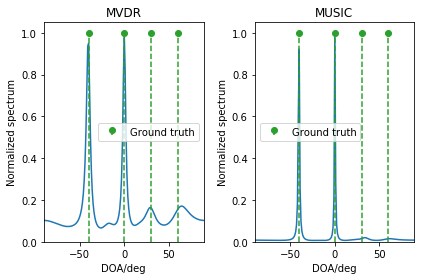

In [3]:
mvdr = estimation.MVDRBeamformer(ula, wavelength, grid)
music = estimation.MUSIC(ula, wavelength, grid)
resv_mvdr, est_mvdr, sp_mvdr = mvdr.estimate(R, sources.size, return_spectrum=True)
resv_mu, est_mu, sp_mu = music.estimate(R, sources.size, return_spectrum=True)

plt.figure()
ax = plt.subplot(1, 2, 1)
doaplt.plot_spectrum(sp_mvdr, grid, ax=ax, ground_truth=sources)
ax.set_title('MVDR')
ax = plt.subplot(1, 2, 2)
doaplt.plot_spectrum(sp_mu, grid, ax=ax, ground_truth=sources)
ax.set_title('MUSIC')
plt.tight_layout()
plt.show()

Unfortunately we can only recover the first two.

## With spatial smoothing

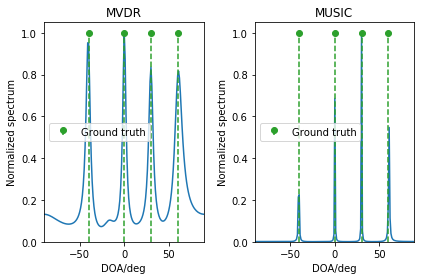

In [5]:
# We have a pair of coherent sources.
# Consider two overlapping subarrays of 9 elements.
l = 2
Rss = estimation.spatial_smooth(R, l, True)
# Each subarray has 9 elements.
ula_ss = model.UniformLinearArray(ula.size - l + 1, d0)

mvdr_ss = estimation.MVDRBeamformer(ula_ss, wavelength, grid)
music_ss = estimation.MUSIC(ula_ss, wavelength, grid)
resv_mvdr, est_mvdr, sp_mvdr = mvdr_ss.estimate(Rss, sources.size, return_spectrum=True)
resv_mu, est_mu, sp_mu = music_ss.estimate(Rss, sources.size, return_spectrum=True)

plt.figure()
ax = plt.subplot(1, 2, 1)
doaplt.plot_spectrum(sp_mvdr, grid, ax=ax, ground_truth=sources)
ax.set_title('MVDR')
ax = plt.subplot(1, 2, 2)
doaplt.plot_spectrum(sp_mu, grid, ax=ax, ground_truth=sources)
ax.set_title('MUSIC')
plt.tight_layout()
plt.show()

Now we can recover all the sources.